In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from keras_tqdm import TQDMNotebookCallback
from matplotlib import rc
rc("font", family="serif", size=14)
from datetime import datetime

Using TensorFlow backend.


In [31]:
def buildIndex(file):
    headers=open(file, 'r').read().split('\n')[0].split(',')
    dictionary={}
    for i,h in enumerate(headers):
        dictionary[h]=i
    return dictionary

def initialData(datafile, indices, age_range=None):
    #indices=[step, mass, age, Teff, L]
    data=np.genfromtxt(datafile, delimiter=',', skip_header=1)
    print(open(datafile, 'r').read().split('\n')[0].split(','))

    evo_tracks=[]
    last_number=-1
    last_index=0
    for i,entry in enumerate(data):
        if entry[indices['step']]<last_number:
            evo_tracks.append(data[last_index:i])
            last_index=i
        if i==len(data)-1:
            evo_tracks.append(data[last_index:])
        last_number=entry[indices['step']]
    
    if age_range==None:
        return evo_tracks
    else:
        range_tracks=[]
        for track in evo_tracks:
            range_track=[]
            for entry in track:
                if entry[indices['age']]>=age_range[0] and entry[indices['age']]<=age_range[1]:
                    range_track.append(entry)
            if len(range_track)>0:
                range_tracks.append(np.array(range_track))
        range_tracks=np.array(range_tracks)
        return evo_tracks, range_tracks

def datatoplot(tracks, indices):
    plot_tracks=[tracks[0][:,indices['Teff']],tracks[0][:,indices['L']]]
    plot_m=[tracks[0][:,indices['mass']]]
    for track in tracks:
        plot_tracks[0]=np.append(plot_tracks[0],track[:,indices['Teff']])
        plot_tracks[1]=np.append(plot_tracks[1],track[:,indices['L']])
        plot_m=np.append(plot_m,track[:,indices['mass']])
    return plot_tracks, plot_m

def plotHR1(tracks, indices):
    plot_tracks,plot_m=datatoplot(tracks, indices)
    fig, ax=plt.subplots(1,1,figsize=[10,10])
    #print(np.ones(10)*np.array([1,2]))
    s1=ax.scatter(np.log(plot_tracks[0]),np.log(plot_tracks[1]),s=5,c=plot_m,cmap='viridis')
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylabel(r'$log(L/L_{\odot})$')
    ax.set_xlabel(r'$log T_{eff}$')
    fig.colorbar(s1)
    plt.show()

def fetchData(data, parameters, indices):
    fIndex=[]
    for p in parameters:
        fIndex.append(indices[p])
    return_array=[]
    if np.shape(data[0])==(len(indices),):
        for i,ind in enumerate(fIndex):
            return_array.append(np.log10(data[:,ind]).astype('float32'))
    else:
        for i,ind in enumerate(fIndex):
            dummy_array=[]
            for d in data:
                dummy_array=np.append(dummy_array,np.log10(d[:,ind]).astype('float32'))
            return_array.append(dummy_array)
    return return_array

def buildModel(New_model,inout_shape=[0,0],no_layers=0,no_nodes=0,reg=None, call_name=None):
    if reg!=None:
        if reg[0]=='l1':
            regu=keras.regularizers.l1(reg[1])
        elif reg[0]=='l2':
            regu=keras.regularizers.l2(reg[1])
    if New_model:
        inputs=keras.Input(shape=(inout_shape[0],))
        if reg==None:
            xx=keras.layers.Dense(no_nodes,activation='relu')(inputs)
        else: xx=keras.layers.Dense(no_nodes,activation='relu',kernel_regularizer=regu)(inputs)
        for i in range(no_layers-1):
            if reg==None:
                xx=keras.layers.Dense(no_nodes,activation='relu')(xx)
            else: xx=keras.layers.Dense(no_nodes,activation='relu',kernel_regularizer=regu)(xx)
        outputs=keras.layers.Dense(inout_shape[1],activation='linear')(xx)
        model = keras.Model(inputs=inputs, outputs=outputs)
    else:
        model = keras.models.load_model(call_name)
    model.summary()
    return model

def compileModel(model, lr, loss, metrics=None, beta_1=0.9, beta_2=0.999):
    optimizer=keras.optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    if metrics!=None:
        model.compile(optimizer=optimizer,loss=loss, metrics=metrics)
    else: model.compile(optimizer=optimizer,loss=loss)

def fitModel(model, inputs, outputs, epoch_no, batch_size, save_name, keep_log=True):
    if keep_log==True:
        logdir = "logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        callback=[tensorboard_callback]
    else: callback=[]

    start_time=datetime.now()
    history=model.fit(np.array(inputs).T,np.array(outputs).T,
                      epochs=epoch_no,
                      batch_size=batch_size,
                      validation_split=0.10,
                      verbose=0,
                      callbacks=callback)
    print('training done! now='+str(datetime.now())+' | Time lapsed='+str(datetime.now()-start_time))
    model.save(save_name)
    return history

def plotHist(history, trial_no, file, plot_MSE=True):
    epoch = history.epoch
    hist=history.history
    MAE,valMAE=hist['MAE'],hist['val_MAE']
    fig, ax = plt.subplots(1, 1)
    ax.plot(epoch,MAE,'b',label='MAE')
    ax.plot(epoch,valMAE,'r',label='valMAE')
    if plot_MSE==True:
        MSE,valMSE = hist['MSE'],hist['val_MSE']
        ax.plot(epoch,MSE,'b:',label='MSE')
        ax.plot(epoch,valMSE,'r:',label='valMSE')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('metric')
    ax.legend()
    plt.show()
    fig.savefig(file+'\\history'+str(trial_no)+'.png')

def plotHR(Teffm, Lm, Mm, Teffg, Lg, Mg, trial_no, file):
    fig, ax=plt.subplots(1,2,figsize=[18,10])
    s1=ax[0].scatter(Teffm,Lm,s=5,c=Mm, cmap='viridis')
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    ax[0].set_ylabel(r'$log(L/L_{\odot})$')
    ax[0].set_xlabel(r'$log T_{eff}$')
    s2=ax[1].scatter(Teffg,Lg,s=5,c=Mg, cmap='viridis')
    ax[1].set_xlim(ax[1].get_xlim()[::-1])
    ax[1].set_ylabel(r'$log(L/L_{\odot})$')
    ax[1].set_xlabel(r'$log T_{eff}$')
    fig.colorbar(s2)
    plt.show()
    fig.savefig(file+'\\HR'+str(trial_no)+'.png')

['', 'star_mass', 'star_age', 'initial_Yinit', 'initial_feh', 'initial_MLT', 'initial_fov', 'effective_T', 'luminosity', 'delta_nu']


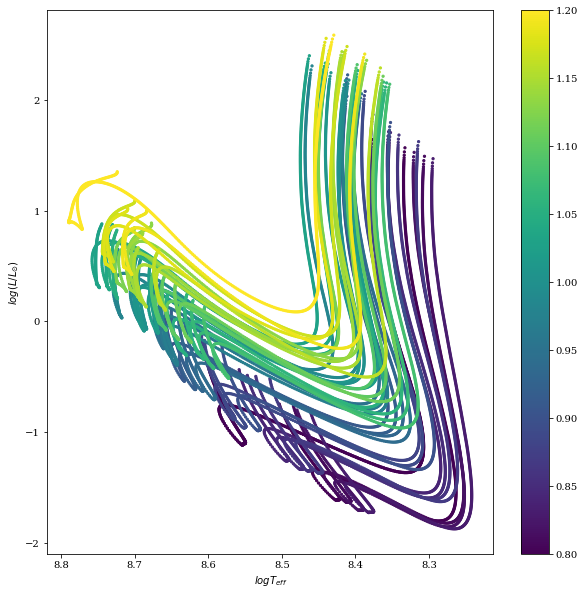

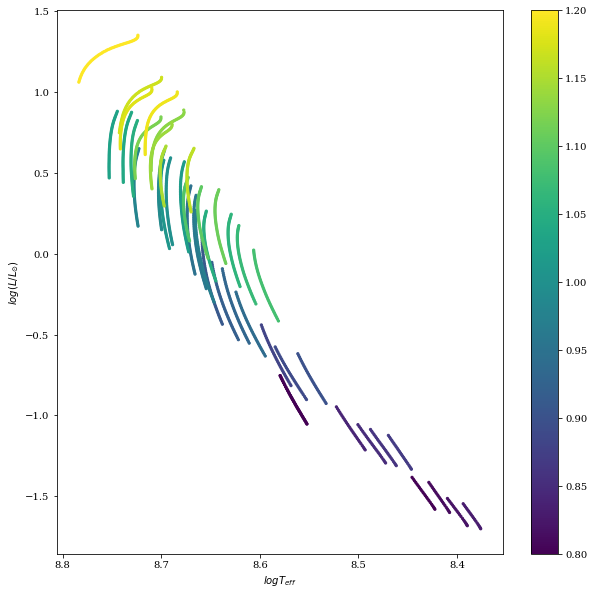

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 3,330
Trainable params: 3,330
Non-trainable params: 0
_________________________________________________________

In [24]:
file='grid_mid_0_0.csv'
index_dict=buildIndex(file)
index_dict['step'] = index_dict.pop('')
index_dict['mass'] = index_dict.pop('star_mass')
index_dict['age'] = index_dict.pop('star_age')
index_dict['Teff'] = index_dict.pop('effective_T')
index_dict['L'] = index_dict.pop('luminosity')
evo, ranged=initialData(file, index_dict, age_range=[1,8])
plotHR1(evo[0::200], index_dict)
plotHR1(ranged[0::200], index_dict)
x_in=fetchData(evo,['mass','age'],index_dict)
y_out=fetchData(evo,['L','Teff'],index_dict)
m1=buildModel(True,inout_shape=[len(x_in),len(y_out)],no_layers=4,no_nodes=32)
#m1=buildModel(False, call_name='small_grid_model_reg.h5')
compileModel(m1, 0.0001,'MAE',metrics=['MAE','MSE'])

In [37]:
epoch_no=1000
class showProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % int(epoch_no/100) == 0:
            percent= int(np.round((epoch/int(epoch_no/100)),0))
            time=datetime.now()
            time_lapsed = (time-start_time)
            print(str(percent)+'% | epoch='+str(epoch)+'/'+str(epoch_no)+' | now='+str(time)[:-7]+
                  ' | time lapsed='+str(time_lapsed)[:-7]+' | loss='+str(np.round(logs['loss'],5)))
logdir = "logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir='logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
            
start_time=datetime.now()
history=m1.fit(np.array(x_in).T,np.array(y_out).T,
                  epochs=epoch_no,
                  batch_size=len(x_in[0]),
                  validation_split=0.10,
                  verbose=0,
                  callbacks=[showProgress()])
print('training done! now='+str(datetime.now())+' | Time lapsed='+str(datetime.now()-start_time))
m1.save('mid_grid_model.h5')

0% | epoch=0/1000 | now=2019-11-18 02:29:29 | time lapsed=0:00:05 | loss=0.09764
1% | epoch=10/1000 | now=2019-11-18 02:29:58 | time lapsed=0:00:33 | loss=0.09715
2% | epoch=20/1000 | now=2019-11-18 02:30:27 | time lapsed=0:01:03 | loss=0.09666
3% | epoch=30/1000 | now=2019-11-18 02:30:55 | time lapsed=0:01:31 | loss=0.09615
4% | epoch=40/1000 | now=2019-11-18 02:31:24 | time lapsed=0:02:00 | loss=0.09552
5% | epoch=50/1000 | now=2019-11-18 02:31:52 | time lapsed=0:02:28 | loss=0.09484
6% | epoch=60/1000 | now=2019-11-18 02:32:21 | time lapsed=0:02:56 | loss=0.09422
7% | epoch=70/1000 | now=2019-11-18 02:32:49 | time lapsed=0:03:25 | loss=0.09362
8% | epoch=80/1000 | now=2019-11-18 02:33:18 | time lapsed=0:03:53 | loss=0.09298
9% | epoch=90/1000 | now=2019-11-18 02:33:46 | time lapsed=0:04:22 | loss=0.09226
10% | epoch=100/1000 | now=2019-11-18 02:34:15 | time lapsed=0:04:50 | loss=0.09141
11% | epoch=110/1000 | now=2019-11-18 02:34:43 | time lapsed=0:05:19 | loss=0.09044
12% | epoch=1

97% | epoch=970/1000 | now=2019-11-18 03:15:23 | time lapsed=0:45:58 | loss=0.05099
98% | epoch=980/1000 | now=2019-11-18 03:15:51 | time lapsed=0:46:26 | loss=0.05093
99% | epoch=990/1000 | now=2019-11-18 03:16:19 | time lapsed=0:46:55 | loss=0.05088
training done! now=2019-11-18 03:16:45.205553 | Time lapsed=0:47:20.734399


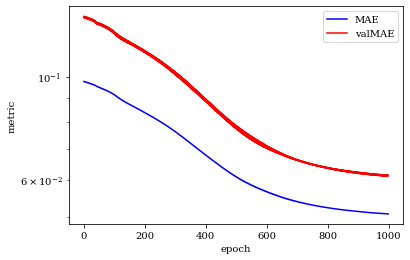

498/1 - 0s - loss: 0.0933 - MAE: 0.0551 - MSE: 0.0102
5060/1 - 0s


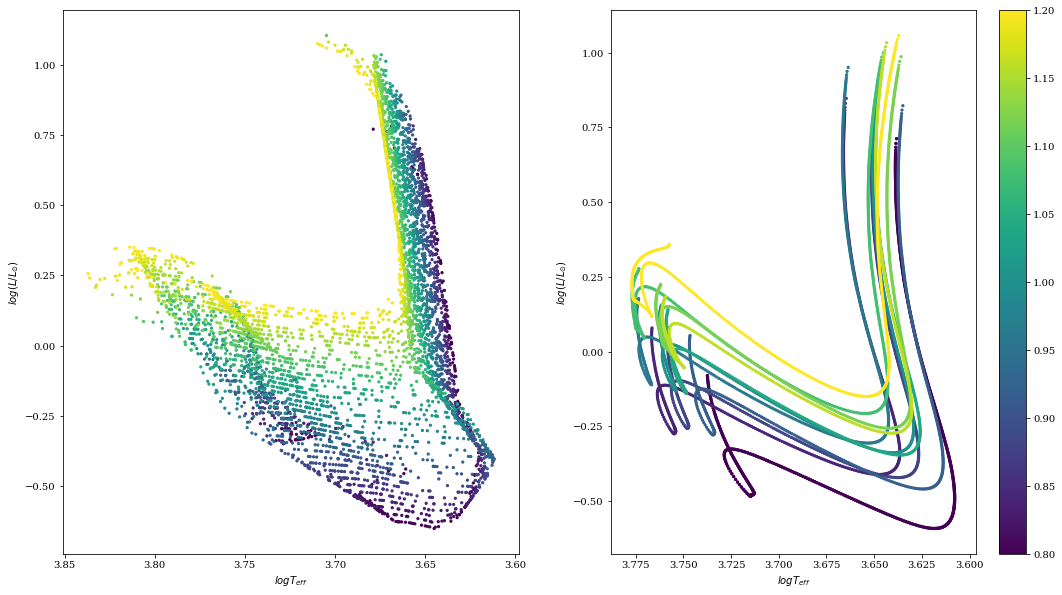

In [38]:
plotHist(history, 2, 'mid_grid_pics', plot_MSE=False)
eva_in=fetchData(evo[10], ['mass','age'],index_dict)
eva_out=fetchData(evo[10],['L','Teff'],index_dict)
m1.evaluate(np.array(eva_in).T,np.array(eva_out).T,verbose=2)
No_tracks=10
sep=int(len(evo)/No_tracks)
NN_tracks=m1.predict(np.array([x_in[0][0::sep],x_in[1][0::sep]]).T,verbose=2).T
NN_m=x_in[0][0::sep]
plot_tracks,plot_m=datatoplot(evo[0::sep],index_dict)
plotHR(NN_tracks[1], NN_tracks[0], NN_m, np.log10(plot_tracks[0]), np.log10(plot_tracks[1]), plot_m, 2, 'mid_grid_pics')

In [30]:
print(len(index_dict))

10


{'initial_Yinit': 3, 'initial_feh': 4, 'initial_MLT': 5, 'initial_fov': 6, 'delta_nu': 9, 'step': 0, 'mass': 1, 'age': 2, 'Teff': 7, 'L': 8}
